# Imports

In [77]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import shap


In [78]:
import numpy as np
import pandas as pd
from sklearn.metrics import explained_variance_score


def drop_high_correlation(X, threshold=0.95):
    # drop highly correlated features

    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

    # So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'dropping_these_features'.
    dropping_these_features = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    X = X.drop(columns=dropping_these_features)

    return X

def drop_x_riskiest_features(df, number_to_drop=10, rolling_window=10, target_column=''):
    correlations = pd.DataFrame()
    columns = df.columns
    
    for column in columns:
        correlations[column] = df[target_column].rolling(rolling_window).corr(df[column])
    to_drop = correlations.std().sort_values(ascending=False).head(number_to_drop).keys()
    
    df.drop(columns=to_drop, inplace=True)
    return df

def get_vol(prices, span=10, delta=pd.Timedelta(days=1)):

    Delta = delta
    # 1. compute returns of the form p[t]/p[t-1] - 1
    # 1.1 find the timestamps of p[t-1] values
    df0 = prices.index.searchsorted(prices.index - delta)
    df0 = df0[df0 > 0]

    # 1.2 align timestamps of p[t-1] to timestamps of p[t]
    df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])

    # 1.3 get values by timestamps, then compute returns
    df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1

    # 2. estimate rolling standard deviation
    df0 = df0.ewm(span=span).std()

    return df0

def get_barriers(daily_volatility, prices, t_final = 5, upper_lower_multipliers = [1.5, 1.5]):

    #create a container
    barriers = pd.DataFrame(columns=['datapoints_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)

    for datapoint, vol in daily_volatility.iteritems():

        datapoints_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : datapoint])

        #set the vertical barrier 
        if (datapoints_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                datapoints_passed + t_final]
        else:
            vert_barrier = np.nan

        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[datapoint] + prices.loc[datapoint] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)

        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[datapoint] - prices.loc[datapoint] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

        barriers.loc[datapoint, ['datapoints_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
        datapoints_passed, prices.loc[datapoint], vert_barrier, top_barrier, bottom_barrier

    return barriers

def get_labels(barriers):
    barriers["label_barrier"] = None
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):

            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]

            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]

            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
              top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
              bottom_barrier).any()

            #assign the labels
            if condition_pt: 
                barriers['label_barrier'][i] = 1 # Top
            elif condition_sl: 
                barriers['label_barrier'][i] = 0 # Bottom  
            else: 
                barriers['label_barrier'][i] = 0.5 # time barrier

    return barriers


def SFI(featNames, split_model, training_data, train_split_index, test_split_index): 
    imp=pd.DataFrame(columns=['score'])
    for featName in featNames:
        split_model.fit(training_data.loc[train_split_index, featName].values.reshape(-1,1),
                    training_data.loc[train_split_index,
                                        ['target']].values.reshape(-1,1))
        y_pred = split_model.predict(training_data.loc[test_split_index, featName].values.reshape(-1,1))
        imp.loc[featName,'score']= explained_variance_score(training_data.loc[test_split_index, 'target'].values.reshape(-1,1), y_pred)
    return imp

In [79]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data loading

In [80]:
ML_FILE = "ml_trades_2024-07-24_10-48-33"
fin_ratios_file = "wrds_finratio.csv"
industry_ratios_file = "wrds_industry.csv"

In [81]:
df = pd.read_csv(f"data/{ML_FILE}.csv")
fin_ratios = pd.read_csv(f"data/{fin_ratios_file}")
industry_ratios = pd.read_csv(f"data/{industry_ratios_file}")

In [82]:
gics_mapping = {
    'Communication Services': 50,
    'Consumer Discretionary': 25,
    'Consumer Staples': 30,
    'Energy': 10,
    'Financials': 40,
    'Health Care': 35,
    'Industrials': 20,
    'Information Technology': 45,
    'Materials': 15,
    'Utilities': 55,
    'Real Estate': 60
}
industry_ratios['gicdesc'] = industry_ratios['gicdesc'].replace(gics_mapping)


In [83]:
last_four_columns = df.iloc[:, -4:]

# Display the selected columns
print(last_four_columns.columns.values)

['cusip' 'rv' 'exit_date' 'trade_length']


In [84]:
pd.read_csv(f'data/meta/{535555106}.csv')

,conm,gvkey,add1,add2,add3,add4,addzip,busdesc,cik,city,conml,costat,county,dlrsn,ein,fax,fic,fyrc,ggroup,gind,gsector,gsubind,idbflag,incorp,loc,naics,phone,prican,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,LINDSAY CORP,14954,"18135 Burke Street, Suite 100",NaN,NaN,NaN,68022,"Lindsay Corporation, together with its subsidi...",836157,Omaha,Lindsay Corp,A,NaN,NaN,47-0554096,402 829 6834,USA,8.0,2010,201060,20,20106015,D,DE,USA,333111,402 829 6800,NaN,NaN,1,3523,357.0,925.0,B,NE,0.0,www.lindsay.com,NaN,1988-10-12


In [93]:
names = []
codes = []
for cusip in df.cusip.values:
    try:
        meta = pd.read_csv(f'data/meta/{cusip}.csv')
        conm = meta.iloc[0].gvkey
        code = meta.iloc[0].gsector
        names.append(conm)
        codes.append(code)
    except:
        names.append('Unknown')
        codes.append('Unknown')      
df['gvkey'] = names
df['gsector'] = codes

In [95]:
with open('data/names.txt', 'w') as file:
    for name in names:
        file.write(f"{name}\n")
        
with open('data/codes.txt', 'w') as file:
    for code in codes:
        file.write(f"{code}\n")


In [96]:
with open('data/names.txt', 'r') as file:
    names = [line.strip() for line in file.readlines()]
df['gvkey'] = names
df['gvkey'] = pd.to_numeric(df['gvkey'], errors='coerce').fillna(-1).astype(int)

with open('data/codes.txt', 'r') as file:
    codes = [line.strip() for line in file.readlines()]
df['gsector'] = codes
df['gsector'] = pd.to_numeric(df['gsector'], errors='coerce').fillna(-1).astype(int)


In [97]:
fin_ratios.drop(columns=['cusip'], inplace=True)


In [98]:
# Calculate the unique cusips in df and fin_ratios
unique_cusips_df = df['gvkey'].unique()
unique_cusips_fin_ratios = fin_ratios['gvkey'].unique()

# Calculate the percentage of cusips from fin_ratios that are in df
cusips_in_df_from_fin_ratios = len(set(unique_cusips_fin_ratios).intersection(unique_cusips_df))
total_unique_cusips_df = len(unique_cusips_df)

percentage_cusips_in_df_from_fin_ratios = (cusips_in_df_from_fin_ratios / total_unique_cusips_df) * 100
print(f"Percentage of gvkey from fin_ratios in df: {percentage_cusips_in_df_from_fin_ratios:.2f}%")

Percentage of gvkey from fin_ratios in df: 80.71%


In [99]:


# Convert 'date' in df to datetime format and adjust to the last day of the previous month
df['date'] = pd.to_datetime(df['date'])
df['date_day'] = df['date'] - pd.offsets.MonthBegin(1)

# Convert 'date_day' to the last day of the previous month
df['date_day'] = df['date_day'] + pd.offsets.MonthEnd(0)

# Convert 'date_day' to string format 'YYYY-MM-DD' if necessary
df['date_day'] = df['date_day'].dt.strftime('%Y-%m-%d')

# Convert 'public_date' in fin_ratios to datetime format if it is not already
fin_ratios['public_date'] = pd.to_datetime(fin_ratios['public_date']).dt.strftime('%Y-%m-%d')
industry_ratios['public_date'] = pd.to_datetime(industry_ratios['public_date']).dt.strftime('%Y-%m-%d')

# Merge the dataframes on 'date_day' and 'cusip'
df = pd.merge(df, fin_ratios, left_on=['date_day', 'gvkey'], right_on=['public_date', 'gvkey'], how='left')
df = pd.merge(df, industry_ratios, left_on=['date_day', 'gsector'], right_on=['public_date', 'gicdesc'], how='left')


In [101]:
df = df.sort_values(by='date')

In [103]:
df = df[df['date'] < '2024-01-01']

In [105]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.33,17.3300,14.82,14.82,614398.0,True,False,28.0,30.0,16.8345,18.260746,15.408254,-0.206224,0.169443,14980.193,9.4,1.91,8599.9,NaN,1076.760010,0.069979,2223.479980,0.072754,10143.809570,0.062442,1255.800049,0.040420,19.105000,0.089036,78.860001,0.093272,NaN,85.309998,3.113,0.125,1.911,4.071,3.946,3.255767,0.347855,0.0,0.0,-0.134880,-1.000000,9.065213,16.009,15.551123,15.284620,33.033808,13.925734,42.716231,34.479690,13.497067,35.775410,40.123119,12.740445,32.647194,1.343465,-2.14,16.581357,NaN,18.640000,0.02,1.0,-12.617925,17.870526,27.749323,-213.246366,0.0,16.019879,38.238994,54.382255,100.000000,28.571429,-71.428571,-0.186590,-0.070214,-0.048050,14.576188,16.2725,17.968812,20.848821,0.071865,0.59500,0.054258,0.109694,0.083407,0.069113,0.064106,0.054454,-0.743981,-0.126179,0.055556,-0.166019,0.020457,0.018567,-7.364572,1.466478,8.337767,86.578322,1,92553H803,0,2010-07-26 00:00:00+00:00,20,133346,45,2010-06-30,93271.0,2009-12-31,2010-03-31,2010-06-30,-8.488,0.517,7.961,-7.536,-7.536,-5.659,-5.659,0.534,-105.420,NaN,-0.093,0.124,0.032,0.213,-0.077,-0.002,0.116,NaN,0.

In [106]:
df['date'] = pd.to_datetime(df['date'], utc=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [107]:
len(df[df["profit_binary"] == 1]) / len(df)

0.6320011643636239

In [108]:
len(df)

116802

In [109]:
df.head()

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.33,17.33,14.82,14.82,614398.0,True,False,28.0,30.0,16.8345,18.260746,15.408254,-0.206224,0.169443,14980.193,9.4,1.91,8599.9,NaN,1076.76001,0.069979,2223.47998,0.072754,10143.80957,0.062442,1255.800049,0.04042,19.105,0.089036,78.860001,0.093272,NaN,85.309998,3.113,0.125,1.911,4.071,3.946,3.255767,0.347855,0.0,0.0,-0.134880,-1.000000,9.065213,16.009,15.551123,15.284620,33.033808,13.925734,42.716231,34.479690,13.497067,35.775410,40.123119,12.740445,32.647194,1.343465,-2.14,16.581357,NaN,18.640000,0.02,1.0,-12.617925,17.870526,27.749323,-213.246366,0.0,16.019879,38.238994,54.382255,100.0,28.571429,-71.428571,-0.186590,-0.070214,-0.048050,14.576188,16.2725,17.968812,20.848821,0.071865,0.59500,0.054258,0.109694,0.083407,0.069113,0.064106,0.054454,-0.743981,-0.126179,0.055556,-0.166019,0.020457,0.018567,-7.364572,1.466478,8.337767,86.578322,1,92553H803,0,2010-07-26 00:00:00+00:00,20,133346,45,2010-06-30,93271.0,2009-12-31,2010-03-31,2010-06-30,-8.488,0.517,7.961,-7.536,-7.536,-5.659,-5.659,0.534,-105.420,NaN,-0.093,0.124,0.032,0.213,-0.077,-0.002,0.116,NaN,0.053,NaN,1.062,

In [110]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'in_index',
       'earnings', 'from_earnings', 'to_earnings',
       ...
       'inv_turn_Median', 'pay_turn_Median', 'rect_turn_Median',
       'sale_equity_Median', 'sale_invcap_Median', 'sale_nwc_Median',
       'accrual_Median', 'rd_sale_Median', 'adv_sale_Median',
       'staff_sale_Median'],
      dtype='object', length=257)

In [111]:
#df = df.iloc[:,:-4]

In [112]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.33,17.3300,14.82,14.82,614398.0,True,False,28.0,30.0,16.8345,18.260746,15.408254,-0.206224,0.169443,14980.193,9.4,1.91,8599.9,NaN,1076.760010,0.069979,2223.479980,0.072754,10143.809570,0.062442,1255.800049,0.040420,19.105000,0.089036,78.860001,0.093272,NaN,85.309998,3.113,0.125,1.911,4.071,3.946,3.255767,0.347855,0.0,0.0,-0.134880,-1.000000,9.065213,16.009,15.551123,15.284620,33.033808,13.925734,42.716231,34.479690,13.497067,35.775410,40.123119,12.740445,32.647194,1.343465,-2.14,16.581357,NaN,18.640000,0.02,1.0,-12.617925,17.870526,27.749323,-213.246366,0.0,16.019879,38.238994,54.382255,100.000000,28.571429,-71.428571,-0.186590,-0.070214,-0.048050,14.576188,16.2725,17.968812,20.848821,0.071865,0.59500,0.054258,0.109694,0.083407,0.069113,0.064106,0.054454,-0.743981,-0.126179,0.055556,-0.166019,0.020457,0.018567,-7.364572,1.466478,8.337767,86.578322,1,92553H803,0,2010-07-26 00:00:00+00:00,20,133346,45,2010-06-30,93271.0,2009-12-31,2010-03-31,2010-06-30,-8.488,0.517,7.961,-7.536,-7.536,-5.659,-5.659,0.534,-105.420,NaN,-0.093,0.124,0.032,0.213,-0.077,-0.002,0.116,NaN,0.

In [113]:
df["profit"] = df["profit"] / 1000


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data preprocessing

### Combine PSAR columns

In [114]:
df['PSAR_0.02_0.2'] = df['PSARl_0.02_0.2'].fillna(0) + df['PSARs_0.02_0.2'].fillna(0)
df.drop(columns=['PSARl_0.02_0.2', 'PSARs_0.02_0.2'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Fill NA values in columns with frequent NAs

In [115]:
df.fillna({'CryptoMarketCap':0, 'BTC': 0, 'from_earnings': 100, 'to_earnings': 100}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Check for any leftover NAs and deal with them

In [116]:
df.isnull().any().any()

True

In [117]:
df = df.fillna(0)

In [118]:
df.isnull().any().any()

False

### Convert all feature columns to float

In [119]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns that will be dropped
non_numeric_cols.extend(last_four_columns.columns.values)
print("Non-numeric columns dropped:", non_numeric_cols)


# Remove 'date' from non-numeric columns if it exists
if 'date' in non_numeric_cols:
    non_numeric_cols.remove('date')

Non-numeric columns dropped: ['date', 'in_index', 'earnings', 'cusip', 'exit_date', 'date_day', 'adate', 'qdate', 'public_date_x', 'divyield', 'TICKER', 'public_date_y', 'divyield_Median', 'cusip', 'rv', 'exit_date', 'trade_length']


In [120]:

# Drop non-numeric columns
df = df.drop(columns=non_numeric_cols)
df = df.astype({col: 'float' for col in df.columns[1:]})

In [121]:
df.head()

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
30760,2010-06-25 00:00:00+00:00,17.33,17.33,14.82,14.82,614398.0,28.0,30.0,16.8345,18.260746,15.408254,-0.206224,0.169443,14980.193,9.4,1.91,8599.9,0.0,1076.76001,0.069979,2223.47998,0.072754,10143.80957,0.062442,1255.800049,0.04042,19.105,0.089036,78.860001,0.093272,0.0,85.309998,3.113,0.125,1.911,4.071,3.946,3.255767,0.347855,0.0,0.0,-0.134880,-1.000000,9.065213,16.009,15.551123,15.284620,33.033808,13.925734,42.716231,34.479690,13.497067,35.775410,40.123119,12.740445,32.647194,1.343465,-2.14,16.581357,0.02,1.0,-12.617925,17.870526,27.749323,-213.246366,0.0,16.019879,38.238994,54.382255,100.0,28.571429,-71.428571,-0.186590,-0.070214,-0.048050,14.576188,16.2725,17.968812,20.848821,0.071865,0.59500,0.054258,0.109694,0.083407,0.069113,0.064106,0.054454,-0.743981,-0.126179,0.055556,-0.166019,0.020457,0.018567,-7.364572,1.466478,8.337767,0.086578,1.0,133346.0,45.0,93271.0,-8.488,0.517,7.961,-7.536,-7.536,-5.659,-5.659,0.534,-105.420,0.000,-0.093,0.124,0.032,0.213,-0.077,-0.002,0.116,0.000,0.053,0.000,1.062,-0.040,-1.090,0.057,0.036,0.185,0.106,0.728,0.861,0.73,0.129,0.109,0.253,0.182,0.337,0.530,4.910,0.155,0.387,0.539,0.336,-0.004,0.077,0.539,2.387,1.189,0.832,0.807,5.014,-0.409,0.488,0.655,1.258,1.538,31.400,7.617,0.870,5.220,4.560,1.413,5.239,5.

# Create train/test split

In [122]:
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

Split dataframe to approximately 80/20 train/test. Should be disabled, if training for a live model to allow for more training data.

In [123]:
split_date = df.at[int(len(df)*0.8),"date"]
split_date = pd.to_datetime("2020-01-01", utc=True)

In [124]:
train_set = df[df['date'] < split_date]
test_set = df[df['date'] >= split_date]

In [125]:
X_train = train_set.loc[:, ~train_set.columns.isin(['date', 'profit', 'profit_binary'])]
y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)


In [126]:
X_test = test_set.loc[:, ~test_set.columns.isin(['date', 'profit', 'profit_binary'])]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [127]:
y_train.value_counts()

1    53780
0    28991
Name: profit_binary, dtype: int64

# Train Meta Model

In [128]:
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

clf.set_params(**cfg)
trained_clf = clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643


In [129]:
X_train

,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
0,17.330000,17.330000,14.820000,14.820000,614398.0,28.0,30.0,16.834500,18.260746,15.408254,-0.206224,0.169443,14980.193,9.4,1.91,8599.9,0.00,1076.760010,0.069979,2223.479980,0.072754,10143.809570,0.062442,1255.800049,0.040420,19.105000,0.089036,78.860001,0.093272,0.000000,85.309998,3.113,0.125,1.911,4.071,3.946,3.255767,0.347855,0.0,0.0,-0.134880,-1.000000,9.065213,16.009000,15.551123,15.284620,33.033808,13.925734,42.716231,34.479690,13.497067,35.775410,40.123119,12.740445,32.647194,1.343465,-2.140000,16.581357,0.02,1.0,-12.617925,17.870526,27.749323,-213.246366,0.0,16.019879,38.238994,54.382255,100.000000,28.571429,-71.428571,-0.186590,-0.070214,-0.048050,14.576188,16.272500,17.968812,20.848821,0.071865,0.595000,0.054258,0.109694,0.083407,0.069113,0.064106,0.054454,-0.743981,-0.126179,0.055556,-0.166019,0.020457,0.018567,-7.364572,1.466478,8.337767,133346.0,45.0,93271.0,-8.488,0.517,7.961,-7.536,-7.536,-5.659,-5.659,0.534,-105.420,0.000,-0.093,0.124,0.032,0.213,-0.077,-0.002,0.116,0.000,0.053,0.000,1.062,-0.040,-1.090,0.057,0.036,0.185,0.106,0.728,0.861,0.730,0.129,0.109,0.253,0.182,0.337,0.530,4.910,0.155,0.387,0.539,0.336,-0.004,0.077,0.539,2.387,1.189,0.832,0.807,5.014,-0.409,0.488,0.655,1.258,1.538,31.400,7.617,0.870,5.220,4.560,1.413,5.239,5.028,0.002,0.000,0.000,

In [130]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[21725  7266]
 [ 2079 51701]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     28991
           1       0.88      0.96      0.92     53780

    accuracy                           0.89     82771
   macro avg       0.89      0.86      0.87     82771
weighted avg       0.89      0.89      0.88     82771



In [131]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Assuming `trained_clf` is your trained model and `X_train` is your training data

# Gain-based feature importance
gain_importance = trained_clf.booster_.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': gain_importance})
print("Gain-based feature importance:\n", gain_importance_df)

# Split-based feature importance
split_importance = trained_clf.booster_.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': split_importance})
print("Split-based feature importance:\n", split_importance_df)

# Permutation importance (optional and more computationally expensive)
perm_importance = permutation_importance(trained_clf, X_train, y_train, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importance.importances_mean})
print("Permutation feature importance:\n", perm_importance_df)

# Plotting feature importance (optional)
import matplotlib.pyplot as plt

# Plot gain-based feature importance
gain_importance_df = gain_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(gain_importance_df['feature'], gain_importance_df['importance'])
plt.xlabel('Gain Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()

# Plot split-based feature importance
split_importance_df = split_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(split_importance_df['feature'], split_importance_df['importance'])
plt.xlabel('Split Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Split')
plt.gca().invert_yaxis()
plt.show()


Gain-based feature importance:
                     feature   importance
0                      open   115.823209
1                      high    91.408279
2                       low    73.281170
3                     close   101.386920
4                    volume   566.539618
5             from_earnings   731.569992
6               to_earnings   969.224005
7             bb_20_2_bbmid    94.834630
8           bb_20_2_bbupper   125.212600
9           bb_20_2_bblower    88.829510
10         bb_20_2_percentb   377.821370
11          bb_20_2_bbwidth   466.910912
12                      GDP   166.967180
13             Unemployment    96.279161
14                Inflation   713.816067
15                       M2   848.978859
16          CryptoMarketCap   486.028069
17                    SP500   812.411766
18                SP500_Vol   555.113533
19                   NASDAQ  2987.139366
20               NASDAQ_Vol   760.157377
21                 DowJones  1183.469327
22             DowJones_V

In [ ]:
# Get top 20 features by Gain-based importance
top20_gain = gain_importance_df.sort_values(by='importance', ascending=False).head(20)
print("Top 20 features by Gain-based importance:\n", top20_gain)

# Get top 20 features by Split-based importance
top20_split = split_importance_df.sort_values(by='importance', ascending=False).head(20)
print("Top 20 features by Split-based importance:\n", top20_split)

# Get top 20 features by Permutation importance
top20_perm = perm_importance_df.sort_values(by='importance', ascending=False).head(20)
print("Top 20 features by Permutation importance:\n", top20_perm)

# Find the common top 20 features across all methods
common_top20_features = set(top20_gain['feature']).intersection(top20_split['feature'], top20_perm['feature'])
print("Top 20 features that scored well in all methods:\n", common_top20_features)

# Convert common top 20 features to DataFrame for display
common_top20_features_df = pd.DataFrame(common_top20_features, columns=['feature'])
print("Common top 20 features across all methods:\n", common_top20_features_df)


Top 20 features by Gain-based importance:
                   feature   importance
25                 Silver  5274.476569
23                   Gold  2389.545332
22           DowJones_Vol  1932.550057
19                 NASDAQ  1842.272296
20             NASDAQ_Vol  1779.165601
31        Treasury_Yield1  1692.884785
33        Treasury_Yield3  1580.651727
24         Gold_Daily_Vol  1372.634940
163                   ptb  1311.857748
6             to_earnings  1231.983153
17                  SP500  1224.665016
27               CrudeOil  1223.507539
37    treasury_yield1_vol  1180.391780
28           CrudeOil_Vol  1170.051518
5           from_earnings  1131.259756
21               DowJones  1115.669898
35     yield_curve_spread  1095.834662
93        garch_vol_close  1090.410912
36   treasury_yield1_ma30  1040.810759
80                STDEV_1   991.848375
Top 20 features by Split-based importance:
                  feature  importance
28          CrudeOil_Vol         140
163                 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


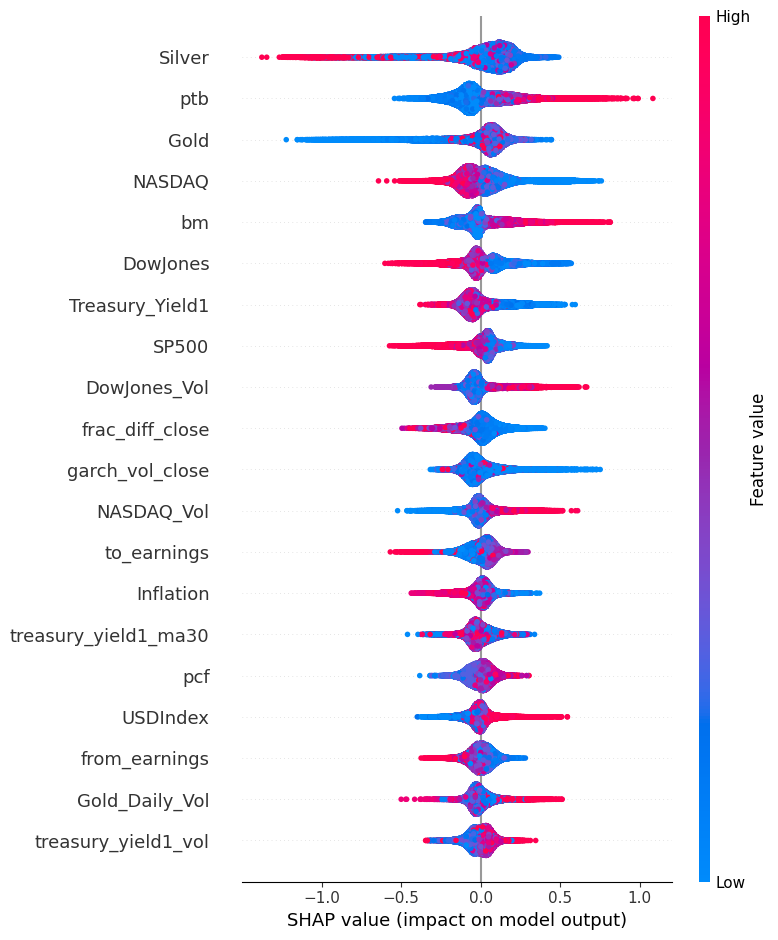

In [69]:
# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

In [118]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_train.iloc[0])


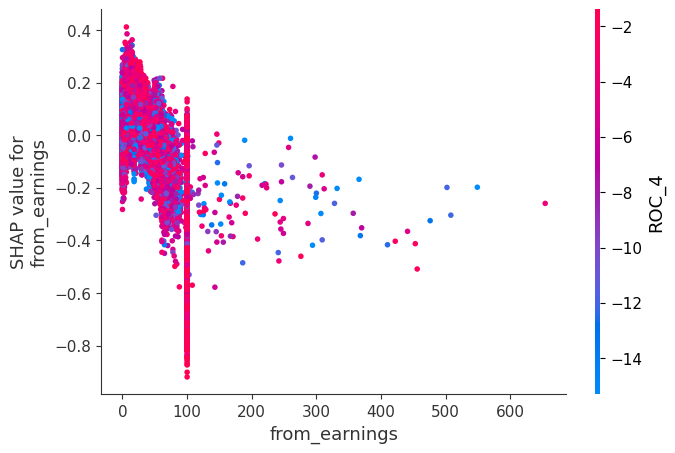

In [121]:
shap.dependence_plot("from_earnings", shap_values[1], X_train)


# Test

In [79]:
ypred = trained_clf.predict(X_test)
ypred

array([0, 1, 0, ..., 1, 1, 1])

In [80]:

pred_df = pd.DataFrame(data = [ypred, y_test.to_numpy()]).T
pred_df.columns = ["prediction", "target"]


In [81]:
pred_df

,prediction,target
0,0,0
1,1,0
2,0,1
3,1,1
4,0,1
...,...,...
37017,1,1
37018,1,1
37019,1,1
37020,1,1


In [82]:
len(pred_df[pred_df['target'] == pred_df['prediction']]) / len(pred_df)

0.5619631570417589

In [83]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[ 4141 10715]
 [ 5502 16664]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.43      0.28      0.34     14856
           1       0.61      0.75      0.67     22166

    accuracy                           0.56     37022
   macro avg       0.52      0.52      0.51     37022
weighted avg       0.54      0.56      0.54     37022



In [84]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[12712  2144]
 [18428  3738]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.41      0.86      0.55     14856
           1       0.64      0.17      0.27     22166

    accuracy                           0.44     37022
   macro avg       0.52      0.51      0.41     37022
weighted avg       0.54      0.44      0.38     37022



In [85]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.9 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.9).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.9 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.9 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.9 Threshold:
[[14479   377]
 [21418   748]]

Classification Report with 0.9 Threshold:
              precision    recall  f1-score   support

           0       0.40      0.97      0.57     14856
           1       0.66      0.03      0.06     22166

    accuracy                           0.41     37022
   macro avg       0.53      0.50      0.32     37022
weighted avg       0.56      0.41      0.27     37022



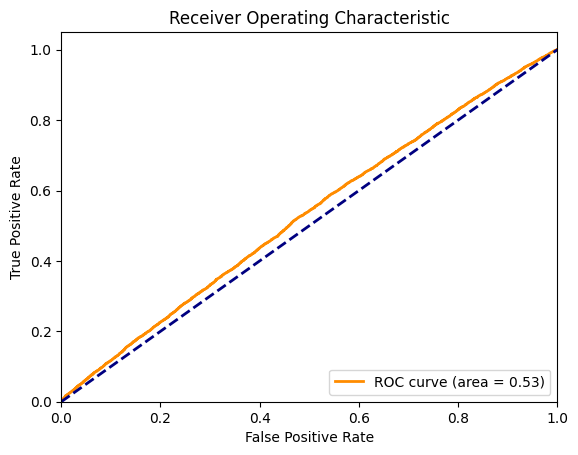

In [86]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [87]:
ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

In [88]:
test_set_with_preds

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,PSAR_0.02_0.2,pred
0,2020-01-02 00:00:00+00:00,16.51,16.55,16.4,16.4,290207.0,1.0,0.0,33.0,47.0,16.4795,16.557404,16.401596,-0.010245,0.009455,21706.513,3.6,1.8,15452.4,6945.01,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.006079,-0.733333,0.582283,16.464,16.439885,16.419192,46.112794,8.111036,30.927476,55.687504,13.490148,23.588238,65.592323,22.783338,18.193265,0.095494,-0.19,16.493475,0.02,1.0,-1.145268,23.543883,49.937865,-96.387513,0.0,16.467326,19.84127,35.343486,100.0,71.428571,-28.571429,-0.007702,-0.003885,-0.003661,16.386192,16.48,16.573808,1.13845,0.073599,0.0175,0.002307,0.003442,0.003713,0.003479,0.004007,0.003624,-0.069034,-0.006061,0.004237,0.316651,-0.001211,0.003359,-2.987636,1.274371,1.773116,-0.096898,0.0,16.61,0.492318
1,2020-01-02 00:00:00+00:00,15.69,15.7,15.22,15.39,1237863.0,1.0,0.0,38.0,36.0,15.995,16.550824,15.439176,-0.044237,0.0695,21706.513,3.6,1.8,15452.4,6945.01,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.014194,-0.625,2.033376,15.549,15.452486,15.412815,55.588343,3.156514,41.30434,50.275896,5.376403,36.608266,46.300126,7.182968,35.095652,0.312937,-0.49,15.595213,0.02,1.0,-3.085642,7.933014,18.151414,-233.774417,0.0,15.585238,12.441966,21.024015,100.0,7.142857,-92.857143,-0.018498,-0.008849,-0.010239,15.298949,15.6175,15.936051,4.079416,0.142915,0.20375,0.010527,0.009131,0.007223,0.00688,0.007417,0.007158,-0.19431,-0.014094,0.005031,0.780716,-0.00128,0.006587,-3.337018,3.32577,0.569187,-0.708706,0.0,16.4,0.603059
2,2020-01-02 00:00:00+00:00,41.3,41.3,38.58,38.99,562733.0,1.0,0.0,38.0,37.0,42.0515,45.04089,39.06211,-0.012061,0.142178,21706.513,3.6,1.8,15452.4,6945.01,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.049535,-0.849265,4.690041,40.063,39.572435,39.368343,50.570488,5.020203,38.086166,38.26827,7.356922,33.36126,28.834732,9.426467,30.675608,1.828647,-2.39,40.916932,0.06,0.0,-5.775737,18.863564,32.534927,-156.836017,0.0,40.177344,31.368945,39.386471,100.0,35.714286,-64.285714,-0.068988,-0.022715,-0.017191,38.755437,40.2775,41.799563,7.557881,0.077054,1.07125,0.03245,0.041267,0.031843,0.02627,0.022049,0.020956,-0.139578,-0.048328,0.014831,0.388144,0.008865,0.015202,-4.447784,21.006162,5.371861,0.144179,1.0,43.795436,0.434944
3,2020-01-02 00:00:00+00:00,21.78,21.82,21.165,21.24,947065.0,1.0,0.0,37.0,23.0,21.6615,22.079413,21.243587,-0.004292,0.038586,21706.513,3.6,1.8,15452.4,6945.01,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.023268,-0.824427,1.483315,21.538,

In [89]:
# profit factor whole dataset
print("Test set base PF:")
print(sum(test_set_with_preds[test_set_with_preds["profit"] > 0]["profit"]) / abs(sum(test_set_with_preds[test_set_with_preds["profit"] <= 0]["profit"])))
print("")

# profit factor with model predictions
print("Test set with > 0.5 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.5]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.8 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.8]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.9 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.9]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

Test set base PF:
1.0205926607571205

Test set with > 0.5 PF:
1.0627081698251966

Test set with > 0.8 PF:
1.4260726136525739

Test set with > 0.9 PF:
2.3562235498085085



In [90]:
def save_model_sklearn(model_name: str):
    """
    Saves models from sklearn to filesystem.

    Args:
        model (sklearn model): Sklearn model.
        path (string): The path to save the model to.
        model_name (string): The name of the model.
    """
    joblib.dump(trained_clf, f'../data/processed/stockscreener/ml_model/{model_name}.joblib')